# インポート等（基本的なもの以外は各セクションで実施）

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

train = pd.read_csv('train.csv').drop(['Name', 'Ticket'], axis=1)
test = pd.read_csv('test.csv').drop(['Name', 'Ticket'], axis=1)

# ターゲットエンコーディングのスムージング

## https://qiita.com/rshinji/items/80e844beab57c9726b12

## クラス

In [2]:
class TargetEncoding_ws(object):
    """
    DFと変換したいカラムリスト、targetを引数として、Target Encoding with Smoothingを行う
    引数
    dataframe : DF全体 (pd.DataFrame)
    target : 目的変数のカラム (np.ndarray or np.Series)
    list_cols : 変換したいカラムリスト (list[str])
    k : smoothingのハイパーパラメータ (int)
    impute : 未知のカテゴリに平均を入れるか (boolean)
    """
    def __init__(self, list_cols, k=100, impute=True):
        self.df = None
        self.target = None
        self.list_cols = list_cols
        self.k = k
        self.impute = impute
        self.target_map = {}
        self.target_mean = None

    def sigmoid(self, x, k):
        return 1 / (1 + np.exp(- x / k))

    def fit_univariate(self, target, col):
        """
        一つの変数に対するTarget_Encoding
        col : TargetEncodingしたい変数名
        """
        df = self.df.copy()
        k = self.k
        df["target"] = target
        n_i = df.groupby(col).count()["target"]

        lambda_n_i = self.sigmoid(n_i, k)
        uni_map = df.groupby(col).mean()["target"]

        return lambda_n_i * df.loc[:, "target"].mean() + (1 - lambda_n_i) * uni_map

    def fit(self, data, target):
        """
        複数カラムにも対応したTargetEncoding
        """
        self.df = data.copy()
        self.target = target

        if self.impute == True:
            self.target_mean = target.mean()

        #各カラムのmapを保存
        for col in list_cols:
            self.target_map[col] = self.fit_univariate(target, col)

    def transform(self, x):
        list_cols = self.list_cols
        x_d = x.copy()
        for col in list_cols:
            x_d.loc[:, col] = x_d.loc[:, col].map(self.target_map[col])

            #impute
            if self.impute == True:
                x_d.loc[:, col] = np.where(x_d.loc[:, col].isnull(), self.target_mean, x_d.loc[:, col])

        return x_d

## データ加工

In [3]:
train_X = train.drop(['Survived'], axis=1)
train_y = train['Survived']

test_X = test

## 適用

In [5]:
list_cols = ["Sex","Cabin", "Embarked"]
te = TargetEncoding_ws(list_cols=list_cols, k=200, impute=False)
te.fit(train_X, train_y)
display(te.transform(train_X).head())
display(te.transform(test_X).head())

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,3,0.373527,22.0,1,0,7.2500,NaN,0.382037
1,2,1,0.445526,38.0,1,0,71.2833,0.691149,0.435019
2,3,3,0.445526,26.0,0,0,7.9250,NaN,0.382037
3,4,1,0.445526,35.0,1,0,53.1000,0.441629,0.382037
4,5,3,0.373527,35.0,0,0,8.0500,NaN,0.382037


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,892,3,0.373527,34.5,0,0,7.8292,NaN,0.386176
1,893,3,0.445526,47.0,1,0,7.0000,NaN,0.382037
2,894,2,0.373527,62.0,0,0,9.6875,NaN,0.386176
3,895,3,0.373527,27.0,0,0,8.6625,NaN,0.382037
4,896,3,0.445526,22.0,1,1,12.2875,NaN,0.382037


## 単なるターゲットエンコーディングよりも差が小さい

In [6]:
train.groupby('Sex')['Survived'].mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

In [7]:
train.groupby('Cabin')['Survived'].mean()

Cabin
A10    0.0
A14    0.0
A16    1.0
A19    0.0
A20    1.0
      ... 
F33    1.0
F38    0.0
F4     1.0
G6     0.5
T      0.0
Name: Survived, Length: 147, dtype: float64

In [8]:
train.groupby('Embarked')['Survived'].mean()

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

# ラベルエンコーディング(trainにないデータがtestにあってもok)

## https://www.it-swarm.jp.net/ja/python/sklearnlabelencoder%E3%81%AE%E5%89%8D%E3%81%AB%E5%80%A4%E3%81%8C%E8%A1%A8%E7%A4%BA%E3%81%95%E3%82%8C%E3%81%AA%E3%81%84/1044255321/

In [9]:
from sklearn.preprocessing import LabelEncoder
import numpy as np


class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)

def get_labels(train_df, test_df, categorical_list):
    label_encoder = LabelEncoderExt()
    train_df_ = train_df.copy()
    test_df_ = test_df.copy()
    for col in categorical_cols:
        label_encoder.fit(train_df[col].fillna('Null').values)
        train_df_[col] = label_encoder.transform(train_df[col].fillna('Null').values)
        test_df_[col] = label_encoder.transform(test_df[col].fillna('Null').values)
    return train_df_, test_df_

In [10]:
display(train_X.head(3))
display(test_X.head(3))

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,3,male,22.0,1,0,7.2500,NaN,S
1,2,1,female,38.0,1,0,71.2833,C85,C
2,3,3,female,26.0,0,0,7.9250,NaN,S


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,892,3,male,34.5,0,0,7.8292,NaN,Q
1,893,3,female,47.0,1,0,7.0000,NaN,S
2,894,2,male,62.0,0,0,9.6875,NaN,Q


In [11]:
categorical_cols = ['Sex', 'Cabin', 'Embarked']
train_X_, test_X_ = get_labels(train_X, test_X, categorical_cols)

In [12]:
display(train_X_.head(3))
display(test_X_.head(3))

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,3,2,22.0,1,0,7.2500,146,3
1,2,1,1,38.0,1,0,71.2833,81,0
2,3,3,1,26.0,0,0,7.9250,146,3


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,892,3,2,34.5,0,0,7.8292,146,2
1,893,3,1,47.0,1,0,7.0000,146,3
2,894,2,2,62.0,0,0,9.6875,146,2


# LGBMのクロスバリデーション

## データ加工

In [42]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
def predict_cv(model, train_x, train_y, test_x):
    preds = []
    preds_test = []
    preds_proba = []
    preds_test_proba = []
    va_indexes = []
    train_AUC_score = []
    train_precision_score = []
    train_recall_score = []
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=6785)
    
    feature_importance_df = pd.DataFrame()
    col = list(train_x.columns)
    feat_df = pd.DataFrame()
    
    # クロスバリデーションで学習・予測を行い、予測値とインデックスを保存する
    for i, (tr_idx, va_idx) in enumerate(kf.split(train_x, train_y)):
        print('-'*50)        
        tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
        tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
        
        
        model.fit(tr_x, tr_y, 
                  eval_set= [(tr_x, tr_y), (va_x, va_y)],
                  eval_metric='binary_logloss',
                  verbose=100, 
                  early_stopping_rounds=20)
        
        
        tr_pred_proba = model.predict_proba(tr_x)[:, 1]
        pred_proba = model.predict_proba(va_x)[:, 1]
        preds_proba.append(pred_proba)
        pred_test_proba = model.predict_proba(test_x)[:, 1]
        preds_test_proba.append(pred_test_proba)
        va_indexes.append(va_idx)
        
        tr_pred = model.predict(tr_x)
        pred = model.predict(va_x)
        preds.append(pred)
        pred_test = model.predict(test_x)
        preds_test.append(pred_test)
        
        fold_feat_df = pd.DataFrame()
        fold_feat_df["Feature_fold{}".format(i)] = col
        fold_feat_df["Importance_fold{}".format(i)] = model.feature_importances_
        feat_df = pd.concat([feat_df, fold_feat_df], axis=1)
        print('  score AUC Train : {:.6f}' .format(roc_auc_score(tr_y, tr_pred_proba)), 
              '  score AUC Valid : {:.6f}' .format(roc_auc_score(va_y, pred_proba)))
        print('  score precision Train : {:.6f}' .format(precision_score(tr_y, tr_pred)), 
              '  score precision Valid : {:.6f}' .format(precision_score(va_y, pred)))
        print('  score recall Train : {:.6f}' .format(recall_score(tr_y, tr_pred)), 
              '  score recall Valid : {:.6f}' .format(recall_score(va_y, pred)))
        train_AUC_score.append(roc_auc_score(tr_y, tr_pred))
        train_precision_score.append(precision_score(tr_y, tr_pred))
        train_recall_score.append(recall_score(tr_y, tr_pred))
        
    # バリデーションデータに対する予測値を連結し、その後元の順番に並べなおす
    va_indexes = np.concatenate(va_indexes)
    preds = np.concatenate(preds, axis=0)
    order = np.argsort(va_indexes)
    pred_train = pd.DataFrame(preds[order])
    
    
    # テストデータに対する予測値の平均をとる
    preds_test = pd.DataFrame(np.mean(preds_test, axis=0))
    train_AUC_score_ = np.mean(train_AUC_score)
    train_precision_score_ = np.mean(train_precision_score)
    train_recall_score_ = np.mean(train_recall_score)
    print('*'*40)
    print('train AUC Score : {:.6f}' .format(train_AUC_score_))
    print('valid AUC Score : {:.6f}' .format(roc_auc_score(train_y, pred_train)))
    print('train AUC Score - valid Score : {:.6f}'.format(train_AUC_score_ - roc_auc_score(train_y, pred_train)))
    
    print('train precision Score : {:.6f}' .format(train_precision_score_))
    print('valid precision Score : {:.6f}' .format(precision_score(train_y, pred_train)))
    print('train precision Score - valid Score : {:.6f}'.format(train_precision_score_ - precision_score(train_y, pred_train)))
    
    print('train recall Score : {:.6f}' .format(train_recall_score_))
    print('valid recall Score : {:.6f}' .format(recall_score(train_y, pred_train)))
    print('train recall Score - valid Score : {:.6f}'.format(train_recall_score_ - recall_score(train_y, pred_train)))
    
    a = feat_df[["Feature_fold0","Importance_fold0"]]
    b = feat_df[["Feature_fold1","Importance_fold1"]].rename(columns={"Feature_fold1":"Feature_fold0", "Importance_fold1":"Importance_fold0"})
    c = feat_df[["Feature_fold2","Importance_fold2"]].rename(columns={"Feature_fold2":"Feature_fold0", "Importance_fold2":"Importance_fold0"})
    d = feat_df[["Feature_fold3","Importance_fold3"]].rename(columns={"Feature_fold3":"Feature_fold0", "Importance_fold3":"Importance_fold0"})
    e = feat_df[["Feature_fold4","Importance_fold4"]].rename(columns={"Feature_fold4":"Feature_fold0", "Importance_fold4":"Importance_fold0"})
    
    feat = pd.concat([a, b, c, d, e]).reset_index()
    indices = feat.groupby("Feature_fold0")["Importance_fold0"].agg("mean").reset_index().sort_values("Importance_fold0", ascending=False)[["Feature_fold0",'Importance_fold0']]
    plt.figure(figsize=(14, 4))
    plt.title("重要度上位50")
    sns.barplot(x="Importance_fold0", y="Feature_fold0", data=feat, order=indices.iloc[:50, 0])
    plt.show()
    return pred_train, preds_test, model

--------------------------------------------------
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[43]	training's binary_logloss: 0.362655	training's binary_logloss: 0.362655	valid_1's binary_logloss: 0.401519	valid_1's binary_logloss: 0.401519
  score AUC Train : 0.917257   score AUC Valid : 0.871476
  score precision Train : 0.872340   score precision Valid : 0.803279
  score recall Train : 0.750916   score recall Valid : 0.710145
--------------------------------------------------
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[51]	training's binary_logloss: 0.365358	training's binary_logloss: 0.365358	valid_1's binary_logloss: 0.38005	valid_1's binary_logloss: 0.38005
  score AUC Train : 0.910463   score AUC Valid : 0.903810
  score precision Train : 0.857143   score precision Valid : 0.862069
  score recall Train : 0.766423   score recall Valid : 0.735294
----------------------------

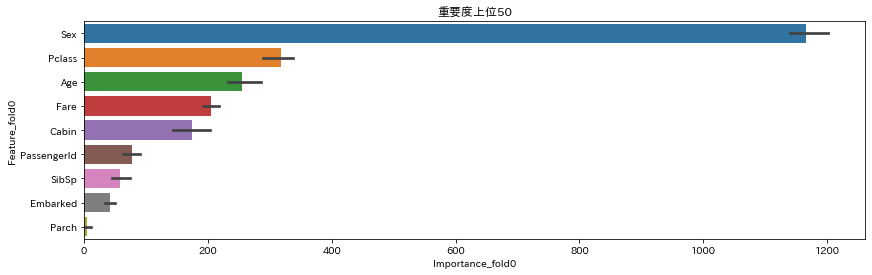

In [43]:
lgbm = lgb.LGBMClassifier(
            nthread=4,
            n_estimators=100,
            learning_rate=0.1,
            maxdepth=2,
            num_leaves=5,
            importance_type='gain')

pred_train, preds_test, lgbm = predict_cv(lgbm, train_X_, train_y, test_X_)

# LGBMは欠損値ありで回るのか？
### 結論：回る

In [44]:
list_cols = ["Sex","Cabin", "Embarked"]
te = TargetEncoding_ws(list_cols=list_cols, k=200, impute=False)
te.fit(train_X, train_y)

X_train_tar = te.transform(train_X)
X_test_tar = te.transform(test_X)

display(X_train_tar.head())
display(X_test_tar.head())

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,3,0.373527,22.0,1,0,7.2500,NaN,0.382037
1,2,1,0.445526,38.0,1,0,71.2833,0.691149,0.435019
2,3,3,0.445526,26.0,0,0,7.9250,NaN,0.382037
3,4,1,0.445526,35.0,1,0,53.1000,0.441629,0.382037
4,5,3,0.373527,35.0,0,0,8.0500,NaN,0.382037


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,892,3,0.373527,34.5,0,0,7.8292,NaN,0.386176
1,893,3,0.445526,47.0,1,0,7.0000,NaN,0.382037
2,894,2,0.373527,62.0,0,0,9.6875,NaN,0.386176
3,895,3,0.373527,27.0,0,0,8.6625,NaN,0.382037
4,896,3,0.445526,22.0,1,1,12.2875,NaN,0.382037


--------------------------------------------------
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[35]	training's binary_logloss: 0.312264	training's binary_logloss: 0.312264	valid_1's binary_logloss: 0.344023	valid_1's binary_logloss: 0.344023
  score AUC Train : 0.933332   score AUC Valid : 0.890119
  score precision Train : 0.862069   score precision Valid : 0.808824
  score recall Train : 0.824176   score recall Valid : 0.797101
--------------------------------------------------
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[62]	training's binary_logloss: 0.295116	training's binary_logloss: 0.295116	valid_1's binary_logloss: 0.307889	valid_1's binary_logloss: 0.307889
  score AUC Train : 0.942520   score AUC Valid : 0.917914
  score precision Train : 0.916667   score precision Valid : 0.980392
  score recall Train : 0.802920   score recall Valid : 0.735294
--------------------------

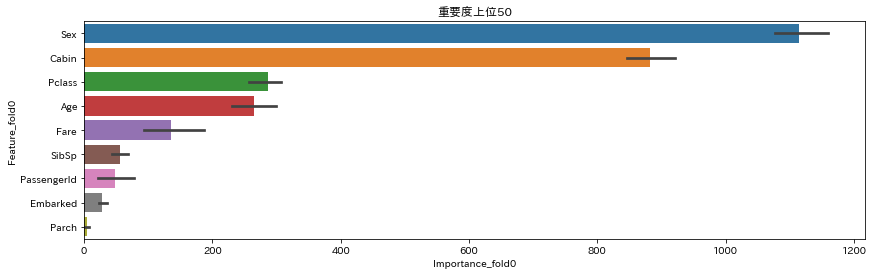

In [45]:
lgbm = lgb.LGBMClassifier(
            nthread=4,
            n_estimators=100,
            learning_rate=0.1,
            maxdepth=2,
            num_leaves=5,
            importance_type='gain')

pred_train, preds_test, lgbm = predict_cv(lgbm, X_train_tar, train_y, X_test_tar)

## トレインデータは欠損値なし、テストデータは欠損値ありの場合も回る

In [49]:
train_non_null = X_train_tar.copy()
train_non_null['Age'] = train_non_null['Age'].fillna(train_non_null['Age'].mean())
train_non_null['Cabin'] = train_non_null['Cabin'].fillna(train_non_null['Cabin'].mean())

--------------------------------------------------
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.307929	training's binary_logloss: 0.307929	valid_1's binary_logloss: 0.341882	valid_1's binary_logloss: 0.341882
  score AUC Train : 0.934750   score AUC Valid : 0.893347
  score precision Train : 0.868726   score precision Valid : 0.803030
  score recall Train : 0.824176   score recall Valid : 0.768116
--------------------------------------------------
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.304813	training's binary_logloss: 0.304813	valid_1's binary_logloss: 0.305389	valid_1's binary_logloss: 0.305389
  score AUC Train : 0.935379   score AUC Valid : 0.925401
  score precision Train : 0.900415   score precision Valid : 0.980392
  score recall Train : 0.791971   score recall Valid : 0.735294
--------------------------

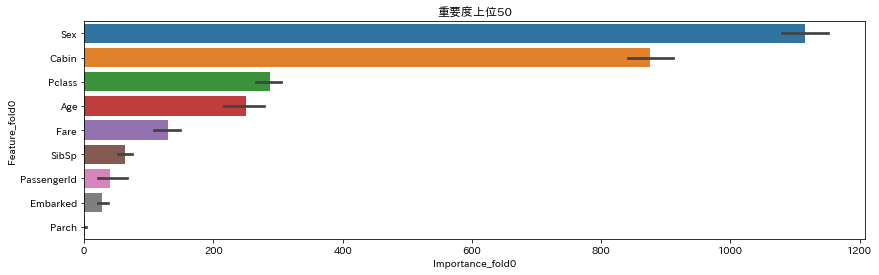

In [51]:
pred_train, preds_test, lgbm = predict_cv(lgbm, train_non_null, train_y, X_test_tar)

### この時ついでにターゲットエンコーディングのスムージングしたデータを入れたが、ラベルエンコーディングよりも過学習が少ない

In [20]:
sub = pd.read_csv('gender_submission.csv')
sub['Survived'] = preds_test[0].astype(int)
sub

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [ ]:
#sub.to_csv('sub_target_smoothing.csv', index=None)